# ViT: Vision Transformers

This notebook is demonstration and explanantion for a vision transformer. This architecture was created to use transformers which were created for language modelling, on images while at the same time changing as little of the transformer architecture as possible. The notebook will have an implementation of the vision transformer and will break down the purpose of each component in the architecture of the vision transformer. Finally it will be trained to perform a simple classification task on the large Food101 dataset.

Reference Paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Prerequisites: 
- Basic understanding of Neural Networks, Transformers


## 1. Introduction:

A Vision Transformer: commonly abbreviated to ViT is transformer that has been specially designed to be used for images. Since transformers usually work with text data where they take a sequence of tokens as an input, they cannot be directly used for the task of working with images. Vision transformers take the image as a sequence of patches. These patches are then fed through the network and the learned representations can then be used for any downstream task. 

The ViT is an encoder only transformer, i.e, it is used to give embeddings of the images that are fed to it, these embeddings are then used for any downstream task, like segmentation, classification e.t.c.


## 2. Architecture

<br>
<center><img src="https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png", width="50%"></center>
<br>

In the image given above we can see the architecture of the ViT. Lets walk through the components and their purpose: -

1. **Patch Embedding:** The patch embedding is responsible for taking each patch of the image and giving an n dimensional embedding. This is similar to how words were embedded in the transformer. The patch embedding is such that after training similar patches will be given similar embeddings.

2. **Positional Embedding:** just like in text where we needed to give positional encoding to the words so that they knew where they were lying, similarly we must do so in images as well. Spatial information of the patches is very important and must be preserved, this is because when the patches are fed to a transformer, all patches interact with each other in a global manner, this is unlike convolutional neural networks where filters are used to ensure only pixels in a neighborhood interact to give output, due to the nature of transformers as a result we need to have positional embedding as well. We add this positional embedding to the patch embedding result of each patch to give us the final patch embeddings.

3. **Transformer Encoder**: the transformer encoder takes in the embeddings and gives an output which are the learned representations of the patches, this contains useful information like the relationships of the patches with each other, like for example what patch is likely to follow a given patch etc. The components of the transformer encoder are as follows: -

    * **Multi-Headed Attention**: attention is the backbone of a transform, it gives us useful information of each individual token. Attention is made up of key, query and value. Where query is for example your patch query, key is for all the other patches in the sequence and their product represents how much your patch is related to to other pathces in the sequence. Finally value is also used, value contains useful information about your specific patch. They all have the same sized embeddings. It is called multi headed attention as there are multiple heads working in parallel which give the final result.

    * **MLP**: the multi-layer perceptron is simply a linear projection of the results of our multi headed attention, it is useful for various reasons such as introducing non-linearity, extracting useful features e.t.c.

    * **Layer Norm**: layer norm is applied to the input before being fed to mlp and attention, it normalises the values across a column ensuring stability during training.

4. **MLP Head**: Finally the mlp head is a projection head that works on the result of the transformer as a whole to perform a downstream task for example classification. The MLP head works only on one patch from the entire sequence of patches that is generated as output of the model. This singular patch can be either a CLS token or it can be created by taking a global average pooling of all the patches.

5. **CLS Token**: the CLS token is a special token that is the same dimensionality as patches after their embedding and it is prepended to the sequence of patches before they are fed to the transformer, a CLS token does not have a positional encoding. The idea for a CLS token is that it will act as a global information holder and will contain an aggregate result of the entire image after training. In some implementation it is used as input to the MLP head for the final task.



## 3. Implementation

In this section we will implement the ViT, and with the help of comments and some documentation explain the reasoning behind the code. Lets first start off with downloading the dataset and exploring it as well as creating various functions that we need to prepare our data to be used in the ViT

### 3.1 Data Exploration and Preparation:

For this section our goal is to perform the following: -

1. Download Dataset: CIFAR10 used for this implementation
2. Create data transformer, loader
3. Create function to prepare an image for it to be used as input to model
4. Create function to visualise an image

In [23]:
import torchvision
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, random_split 
from time import time

In [24]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
batch_size=64

In [25]:
transformer = transforms.Compose([
    transforms.Resize(size=(IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transformer)
valset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transformer)

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, drop_last=True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Trainset Length: {len(trainset)}")
print(f"Valset Length: {len(valset)}")

Files already downloaded and verified
Files already downloaded and verified
Trainset Length: 50000
Valset Length: 10000


In [26]:
# Get one batch of images for testing purposed

images, labels = next(iter(trainloader))
print(images.shape) # (B, C, H, W) -> Batch, Channel, Height, Width (this convention will be used)
print(labels.shape) # (B,) -> Batch

torch.Size([64, 3, 64, 64])
torch.Size([64])


In [27]:
def visualise_img(data):
    # data -> (C, H, W)
    img = data.detach().numpy().transpose(1, 2, 0) # to take C to last channel
    mean = np.array([0.49139968, 0.48215827 ,0.44653124])
    std = np.array([0.24703233, 0.24348505, 0.26158768])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    return img

(-0.5, 63.5, 63.5, -0.5)

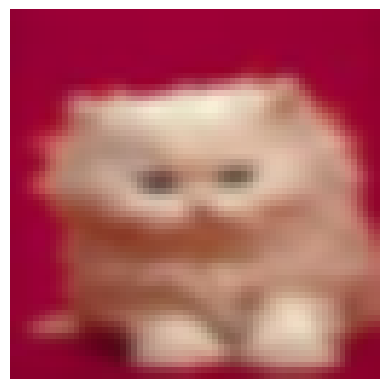

In [28]:
plt.imshow(visualise_img(images[1]))
plt.axis('off')

In [29]:
patch_h = 4
patch_w = 4
num_patches = (IMG_HEIGHT // patch_h) ** 2

In [30]:
# Create function to get image patches

def get_patches(imgs):
    B, C, H, W = imgs.shape
    patches = imgs.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
    patches = patches.contiguous().view(B, C, -1, patch_h, patch_w) # (B, C, P, h, w)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches

In [31]:
def prepare_images(imgs):
    patches = get_patches(imgs)
    B, P, C, h, w = patches.shape
    patches_flat = patches.reshape(B, P, C*h*w)
    return patches_flat

In [32]:
# Running prepare images function: -

print(f"Input images: {images.shape}")
print(f"Input to ViT: {prepare_images(images).shape}")

Input images: torch.Size([64, 3, 64, 64])
Input to ViT: torch.Size([64, 256, 48])


This works perfectly as we need the ViT to get the input of the images as flattened patches. Now we can get started on the implementation of the actual model.

### 3.2 Model Implementation:

For this section our goal is to perform the following: -

1. Construct the ViT and all its components
2. Train the model on our image data
3. Evaluate the model performance on test set

In [33]:
patches = prepare_images(images)
patches.shape

torch.Size([64, 256, 48])

In [34]:
eval_iters = 50

In [35]:
@torch.no_grad() # tells torch that computation graph does not need to be maintained for following operations as there will be no backprop
def get_losses():
    """Get loss for train and val split

    Returns:
        _type_: _description_
    """
    model.eval() # put model in evaluation mode
    out = {}
    for split in ['train', 'val']:
        loader = trainloader if split == 'train' else valloader
        losses = torch.zeros(eval_iters)
        k = 0
        for images, labels in iter(loader):
            patches = prepare_images(images)
            cls_patch, loss = model(patches, labels)
            losses[k] = loss.item()
            k += 1
            if k == eval_iters:
                break
        out[split] = losses.mean()
    model.train() # model needs to be put back into training mode
    return out

**Q) What is attention?**

Ans) Attention is an important concept that forms the very backbone of the transformer, it is the reason transformers perform so well at languge modelling tasks and even at image tasks. Attention gives us the important relationships between the tokens in a sequence, which in this case is the patches of an image. Attention has multiple components, the query, the key and the value.

The query can be likened to a term we are trying to search to get related results, this can be thought of as 1 current patch, the key is likened to all the patches in the sequence including the patch in the query itself. The product between these two results will give high values for patches that are related and low for those that are not. The value then is information about a particular token for example how red is it, does it have lines e.t.c, this is then multiplied with the product of the key and query. These are then our attention weights. The learned weights (values of key, qeury, value matrix) will be fixed but they will give different output depending on the input this is the attention weights.

Softmax is used to normalise the values to make it come between 0 and 1, sometimes we also use masking (given in transformer section), this is done to help the model learn to predict even if it is given context of varying length (this is given in more detail in decoder only transformer).

**Q) Why use multiple heads of attention?**

Ans) The idea for using multiple heads of attention is that different heads of attention will focus on different types of relationships, for example one head might focus on the actual meaning of words in a sentence, while another would focus on the grammar of the words in the sentence. Similarly for images, they would focus on different parts or objects in an image, some might focus on the sun in a background another might focus on the people. These heads also work in parallel and they work on the entire sequence however the difference is that they project it to an embedding of size n_embd // num of heads, this is so that after all the outputs are found, they can be concatenated together to give an output of size n_embd and the shape is thus maintained.

In [ ]:
class Head(nn.Module):
    """Single head of attention for transformer

    Args:
        nn (_type_): built on nn.Module
    """

    def __init__(self, n_embd, head_size) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size) # this represents the other patches think of them as tags
        self.query = nn.Linear(n_embd, head_size) # this represents the tokens as queries
        self.value = nn.Linear(n_embd, head_size) # information about each token
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Since this is self attention k,q,v are all made from x itself
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / (k.size(-1) ** 0.5)  
        wei = F.softmax(wei, dim=-1) # probability of each patch wrt other patches
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v # adds individual information of each token to the interrelated information found
        return out

class MultiHeadedAttention(nn.Module):
    """Multi-headed attention for transformer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        assert n_embd % num_heads == 0, f"Embedding size: {n_embd} not divisible num of heads: {num_heads}"
        self.head_size = n_embd // num_heads
        self.heads = nn.ModuleList([Head(n_embd, self.head_size) for _ in range(num_heads)])
        self.c_proj = nn.Linear(n_embd, n_embd)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Multiple heads give out of head_size which when concatenated become -> n_embd
        out = self.c_proj(out)
        return out

**Q) What is the need for a MLP in the transformer block?**

Ans) THe MLP in the transformer block is very important, although it simply takes the input of size n_embd and projects it back to the same size in the process it adds non linearity to the learned representations from attention. This is done with the help of the GeLU activation funciton. Adding non linearity helps it learn more complicated relationships and helps the model generalise better to new data.

In [ ]:
class MLP(nn.Module):
    """Multi-Layer Perceptron within Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

**Q) What does the transformer encoder block do? Why is it useful?**

The transformer encoder block is responsible for learning and giving embeddings for the input data, these embeddings are very rich in information as compared to the raw data that is fed to a model. Embeddings that are given as output can be used an input to other models for various tasks such as image segmentation, object recognition etc. The reason being that it has been found that we can pretrain on a large dataset and train an encoder to give us image embeddings and then we can use those embeddings in a downstream task like segmentation, and performance is boosted as compared to simply using the raw input images to the segmentation model. Decoders are used to generate output and sometimes we have transformers that have both encoder as well as decoders, where the output of the encoder is given as input to the decoder.

**Q) What is layer norm? Why do we need it?**

Layer norm, normalises along the column rather than along the batch, this helps all the values for a particular sample to be in the range of 0 and 1, this helps training be more stable, and the model learns better, depending on implementation layer norm can be done before or after the data is fed to the attention and mlp.

**Q) Why is x added to the output of the attention and then the same is done even following output from the mlp?**

Ans) This is called a residual-skip connection. Think of the model training as a highway, we have our car that zips down the main highway, this is fast and convinient but you are not able to make any stops and perform your daily tasks of buying groceries. What you could do is get off the highway and go into a lane where you could take your time, complete your tasks and then go back to the highway where you can move on with the journey. Similarly the model goes into a branch where it performs tasks like attention, mlp etc the issue with this is that when backpropogating, the gradient could become very small for the input that was given to that block and it hence cant update properly. Addition distributes gradients equally, so by adding x to the output we are distributing gradient equally to both x and to the block of attention, this way both update properly.

In [ ]:
class TransformerEncoder(nn.Module):
    """Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        self.attn = MultiHeadedAttention(n_embd, num_heads)
        self.mlp = MLP(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # this is a residual skip connection, it allows gradients to flow back easily to input
        x = x + self.mlp(self.ln2(x)) # you can see the fact that input is added to output of attn and mlp in the diagram given
        return x

**Q) What is the MLP head? What is a CLS token?**

MLP Head is basically a linear projection that is applied on the output of your transformer, this is task specific and in this case it is implemented to perform classification, the reason it is needed is because we want to perform classification task so that we can see how good a representation our embeddings are of the image, because we need to compute a loss in order to backpropogate and update the network, because we need a loss function this MLP head exists to project embeddings into the number of classes so that we can compute a loss. When using the ViT for getting embeddings of patches, we do not use this head, it serves a purpose only during training. In approaches like Self Supervised Learning where we dont require labels to compute loss, we do not have an MLP head.

A CLS token is a special token that is prepended to the sequence of patches it is the same shape as the other patches after embedding. This token is a special learned vector, ie it will have the same value weights for all sequences. The idea is that after compute, the global informaion of the image will aggregate and flow to the CLS token making the CLS patch output the representation for the entire image. The reason this happens is because during training we have made sure that only the CLS patch is given as input to the MLP head, so the model realises it needs to accumalate global information of the image into CLS patch as it is the only patch being given for classification which will give the final loss.

In [ ]:
class MLPHead(nn.Module):
    """MLP Projection Head for classification

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_classes) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.Tanh(),
            nn.Linear(4*n_embd, num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

**Q) Why do we need positional encodings?**

When we usually work with images, we are working with CNN models, these models have convolutional layers where filters work on neighborhood of pixels and then give on pixel output. So they inherinetly work with pixel location information due to the nature of how filters work, on the other hand attention works in a global manner and so local information is not inherently present because of this we need to add positional information to the patches. There are multiple ways of doing this, sinusoidal encodings are one of them, we use sine becuase it has a range and is periodic so it repeats, initially we stretch the sine function to a large extent and store that in the first index of the positional encoding for a patch, this will just give very general information for where the patch lies, however we then reduce the stretch of the function and as we keep reducing it, it will give more and more specific information. Eg initially it will tell you that patch is in the beginning but not where in the beginning, later positions will say it is the second patch. (this is a very simplified example for more detail check: [youtube link](https://www.youtube.com/watch?v=1biZfFLPRSY))

In [ ]:
def get_position_enc(num_patch, n_embd):
    """Gives sinusoidal positional encodings

    Args:
        nn (_type_): _description_
    """
    assert n_embd % 2 == 0, f"{n_embd} should be even for positional encoding"

    y_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    x_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, n_embd // 2, 2).float() * (-torch.log(torch.tensor(1000.0)) / (n_embd // 2)))

    pos_encoding = torch.zeros((num_patch, n_embd))
    pos_encoding[:, 0::4] = torch.sin(y_pos * div_term)
    pos_encoding[:, 1::4] = torch.cos(y_pos * div_term)
    pos_encoding[:, 2::4] = torch.sin(x_pos * div_term)
    pos_encoding[:, 3::4] = torch.cos(x_pos * div_term)

    return pos_encoding

Finally we can create the ViT, using all the components created above. Explanation for these components is given in architecture and in the above sections.

In [ ]:
class ViT(nn.Module):
    """Vision Transfomer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, num_patches, n_embd, num_heads, num_enc_blocks, num_classes) -> None:
        super().__init__()
        self.patch_embedding = nn.Linear(3*patch_h*patch_w, n_embd) # embeds the patches
        self.pos_encoding = get_position_enc(num_patches, n_embd) # adds positional information to patches
        self.encoder = nn.Sequential(*[TransformerEncoder(n_embd, num_heads) for _ in range(num_enc_blocks)]) # xL number of encoder blocks
        self.mlp_head = MLPHead(n_embd, num_classes) # linear projection head for classification
        self.cls_token = nn.Parameter(torch.randn(size=(1, n_embd))) # special token for aggregating global information

    def forward(self, x, y=None):
        patch_embd = self.patch_embedding(x)
        patch_embd += self.pos_encoding # (B, P, n_embd)
        cls_tokens = self.cls_token.expand(size=(64, *self.cls_token.shape)) # (B, 1, n_embd)
        tokens = torch.cat([cls_tokens, patch_embd], dim=1) # (B, P+1, n_embd)
        representations = self.encoder(tokens) # (B, P+1, n_embd)
        cls_patch = representations[:, 0, :] # (B, n_embd)
        logits = self.mlp_head(cls_patch) # logits of each class
        
        if y is None:
            return cls_patch, logits # if labels not provided i.e, we are performing inference we want logits
        else:
            loss = F.cross_entropy(logits, y) # performs softmax and then negative log likelihood to find loss
            return cls_patch, loss

Putting all these components together for easy readability: -

In [36]:
class Head(nn.Module):
    """Single head of attention for transformer

    Args:
        nn (_type_): built on nn.Module
    """

    def __init__(self, n_embd, head_size) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size) # this represents the other patches think of them as tags
        self.query = nn.Linear(n_embd, head_size) # this represents the tokens as queries
        self.value = nn.Linear(n_embd, head_size) # information about each token
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Since this is self attention k,q,v are all made from x itself
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / (k.size(-1) ** 0.5)  
        wei = F.softmax(wei, dim=-1) # probability of each patch wrt other patches
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v # adds individual information of each token to the interrelated information found
        return out
    

class MultiHeadedAttention(nn.Module):
    """Multi-headed attention for transformer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        assert n_embd % num_heads == 0, f"Embedding size: {n_embd} not divisible num of heads: {num_heads}"
        self.head_size = n_embd // num_heads
        self.heads = nn.ModuleList([Head(n_embd, self.head_size) for _ in range(num_heads)])
        self.c_proj = nn.Linear(n_embd, n_embd)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Multiple heads give out of head_size which when concatenated become -> n_embd
        out = self.c_proj(out)
        return out
    
class MLP(nn.Module):
    """Multi-Layer Perceptron within Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out
    
class TransformerEncoder(nn.Module):
    """Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        self.attn = MultiHeadedAttention(n_embd, num_heads)
        self.mlp = MLP(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # this is a residual skip connection, it allows gradients to flow back easily to input
        x = x + self.mlp(self.ln2(x)) # you can see the fact that input is added to output of attn and mlp in the diagram given
        return x

class MLPHead(nn.Module):
    """MLP Projection Head for classification

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_classes) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.Tanh(),
            nn.Linear(4*n_embd, num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

def get_position_enc(num_patch, n_embd):
    """Gives sinusoidal positional encodings

    Args:
        nn (_type_): _description_
    """
    assert n_embd % 2 == 0, f"{n_embd} should be even for positional encoding"

    y_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    x_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, n_embd // 2, 2).float() * (-torch.log(torch.tensor(1000.0)) / (n_embd // 2)))

    pos_encoding = torch.zeros((num_patch, n_embd))
    pos_encoding[:, 0::4] = torch.sin(y_pos * div_term)
    pos_encoding[:, 1::4] = torch.cos(y_pos * div_term)
    pos_encoding[:, 2::4] = torch.sin(x_pos * div_term)
    pos_encoding[:, 3::4] = torch.cos(x_pos * div_term)

    return pos_encoding

class ViT(nn.Module):
    """Vision Transfomer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, num_patches, n_embd, num_heads, num_enc_blocks, num_classes) -> None:
        super().__init__()
        self.patch_embedding = nn.Linear(3*patch_h*patch_w, n_embd) # embeds the patches
        self.pos_encoding = get_position_enc(num_patches, n_embd) # adds positional information to patches
        self.encoder = nn.Sequential(*[TransformerEncoder(n_embd, num_heads) for _ in range(num_enc_blocks)]) # xL number of encoder blocks
        self.mlp_head = MLPHead(n_embd, num_classes) # linear projection head for classification
        self.cls_token = nn.Parameter(torch.randn(size=(1, n_embd))) # special token for aggregating global information

    def forward(self, x, y=None):
        patch_embd = self.patch_embedding(x)
        patch_embd += self.pos_encoding # (B, P, n_embd)
        cls_tokens = self.cls_token.expand(size=(64, *self.cls_token.shape)) # (B, 1, n_embd)
        tokens = torch.cat([cls_tokens, patch_embd], dim=1) # (B, P+1, n_embd)
        representations = self.encoder(tokens) # (B, P+1, n_embd)
        cls_patch = representations[:, 0, :] # (B, n_embd)
        logits = self.mlp_head(cls_patch) # logits of each class
        
        if y is None:
            return cls_patch, logits # if labels not provided i.e, we are performing inference we want logits
        else:
            loss = F.cross_entropy(logits, y) # performs softmax and then negative log likelihood to find loss
            return cls_patch, loss


In [39]:
eval_interval = 500
num_epochs = 10

In [40]:
model = ViT(num_patches, n_embd=100, num_heads=5, num_enc_blocks=3, num_classes=10)
optimizer = torch.optim.AdamW(lr=1e-3, params=model.parameters())
curr_iter = 0
losses = []
print(f"Number of total parameters: {sum([torch.numel(p) for p in model.parameters()])}") 

Number of total parameters: 413310


In [41]:
# To train the model

for epoch in range(num_epochs):
    for images, labels in iter(trainloader):
        patches = prepare_images(images) # Get patched images
        cls_patch, loss = model(patches, labels) # Get cls patch and loss

        if curr_iter % eval_interval == 0:
            t1 = time()
            losses_split = get_losses() # Get loss on train and validation set
            t2 = time()
            print(f"Step {curr_iter}: Train Loss: {losses_split['train']:.4f} Val Loss: {losses_split['val']:.4f} Time Taken: {t2-t1} seconds")
            
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        curr_iter += 1
        losses.append(loss.item())

Step 0: Train Loss: 2.3133 Val Loss: 2.3157 Time Taken: 39.698909282684326 seconds
Step 500: Train Loss: 1.3670 Val Loss: 1.3853 Time Taken: 38.39172577857971 seconds
Step 1000: Train Loss: 1.1904 Val Loss: 1.2501 Time Taken: 40.65891790390015 seconds
Step 1500: Train Loss: 1.1726 Val Loss: 1.2068 Time Taken: 45.60847783088684 seconds
Step 2000: Train Loss: 1.0730 Val Loss: 1.1166 Time Taken: 47.03711795806885 seconds
Step 2500: Train Loss: 0.9726 Val Loss: 1.0774 Time Taken: 46.60057616233826 seconds
Step 3000: Train Loss: 1.0026 Val Loss: 1.0889 Time Taken: 54.588908672332764 seconds
Step 3500: Train Loss: 0.9218 Val Loss: 1.0282 Time Taken: 48.073211908340454 seconds
Step 4000: Train Loss: 0.8356 Val Loss: 1.0178 Time Taken: 45.890907764434814 seconds
Step 4500: Train Loss: 0.9478 Val Loss: 1.0647 Time Taken: 49.04400300979614 seconds
Step 5000: Train Loss: 0.8133 Val Loss: 0.9606 Time Taken: 49.41571092605591 seconds
Step 5500: Train Loss: 0.7645 Val Loss: 0.9744 Time Taken: 45.766

In [175]:
# torch.save(model, '../SavedModels/vit.pth')

In [43]:
model = torch.load('../SavedModels/vit2.pth')

### 3.3 Model Evaluation

We will check classification report to see how good the model is at learning, and use metrics like classwise precision, accuracy, recall and the f1 score to see how well our model is performing.

In [44]:
from sklearn.metrics import classification_report

In [45]:
print(len(valset))

10000


In [46]:
for images, labels in iter(valloader):
    patches = prepare_images(images) # Get patched images
    cls_patch, logits = model(patches) # Get cls logits and loss
    probs = F.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1)
    print(classification_report(labels, preds))
    break

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.67      0.67      0.67         3
           2       0.50      0.50      0.50         2
           3       0.80      0.67      0.73         6
           4       0.33      0.50      0.40         6
           5       0.71      0.71      0.71         7
           6       0.90      0.82      0.86        11
           7       0.83      0.71      0.77         7
           8       0.83      0.71      0.77         7
           9       0.82      1.00      0.90         9

    accuracy                           0.73        64
   macro avg       0.72      0.70      0.70        64
weighted avg       0.76      0.73      0.74        64



## 4. Understanding and Exploring Model Predictions